# 1. Install and Import

In [1]:
import warnings
from datetime import datetime
from tqdm.contrib import itertools as tqdm_itertools
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier
from scipy.stats import binom, norm
from statsmodels.api import OLS as sm_ols, add_constant as sm_add_constant
import matplotlib.pyplot as plt

c:\Users\mazza\AppData\Local\Programs\Python\Python311\venvs\dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

# 2. Constants

In [3]:
NULL_SOWING_STRATEGIES = ["random", "non-random"]
NULL_PCTS = [.05, .10, .20, .50]
N_ITER_BOOTSTRAP = 25
PVALUE_THRESHOLD = .01
DATASET_NAMES = [
    "bank",
    "blood",
    "cancer",
    "credit",
    "diabetes",
    "electrical_grid",
    "employee",
    "heart",
    "heart_disease",
    "juice",
    "nba",
    "wine",
    "telescope",
    "us_presidential_election_results"]

# 3. Utils

In [4]:
def get_dataset(dataset_name):
    """Get dataset."""
    target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
    df = get_data(dataset_name, verbose=False)
    X, y = df.drop(target_name, axis=1), df[target_name]
    y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])})
    num_features = X.columns[X.apply(is_numeric)].tolist()
    cat_features = [c for c in X.columns if c not in num_features]
    X[cat_features] = CatBoostEncoder().fit_transform(X[cat_features].fillna("NULL"), y)
    return X, y, num_features, cat_features

def is_numeric(x):
    """Check whether an object is numeric."""
    try:
        x+0
        return True
    except:
        return False

def null_sow(X, null_pct, strategy):
    if strategy == "random":
        mask = np.random.uniform(size=X.shape) <= null_pct
    elif strategy == "non-random":
        mask = (X.rank(method="first", ascending=np.random.choice([True, False]), pct=True) / .5 * null_pct).applymap(lambda p: np.random.choice([False, True], p=[1-p,p]))
    else:
        raise Exception(f"Unknown strategy: '{strategy}'")
    X_null = X.mask(mask)
    return X_null

# 4. Dataset menu

In [5]:
datasets = get_data()

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
0,anomaly,Multivariate,Anomaly Detection,NaN,NaN,1000,10,N
1,france,Multivariate,Association Rule Mining,InvoiceNo,Description,8557,8,N
2,germany,Multivariate,Association Rule Mining,InvoiceNo,Description,9495,8,N
3,bank,Multivariate,Classification (Binary),deposit,NaN,45211,17,N
4,blood,Multivariate,Classification (Binary),Class,NaN,748,5,N
5,cancer,Multivariate,Classification (Binary),Class,NaN,683,10,N
6,credit,Multivariate,Classification (Binary),default,NaN,24000,24,N
7,diabetes,Multivariate,Classification (Binary),Class variable,NaN,768,9,N
8,electrical_grid,Multivariate,Classification (Binary),stabf,NaN,10000,14,N
9,employee,Multivariate,Classification (Binary),left,NaN,14999,10,N


# 5. Define pipelines

In [6]:
pipeline_impute = Pipeline([
    ("feature_union", FeatureUnion([
        ("missing_indicator", MissingIndicator()),
        ("imputer", IterativeImputer())])),
    ("model", LGBMClassifier(verbose=-1))])

pipeline_no_impute = Pipeline([
    ("feature_union", FeatureUnion([
        ("missing_indicator", MissingIndicator()),
        ("identity_transformer", FunctionTransformer())])),
    ("model", LGBMClassifier(verbose=-1))])

# 6. Run experiment

In [7]:
results = pd.DataFrame(columns = ["dataset", "null_sowing", "null_pct", "n_rows", "n_cols", "ap_original", "ap_noimpute", "ap_impute"])

for dataset_name, null_sowing_strategy, null_pct in tqdm_itertools.product(DATASET_NAMES, NULL_SOWING_STRATEGIES, NULL_PCTS):

    # the unique id of the trial is made by the pair of dataset name and % of nulls
    id = f"{dataset_name}_{null_sowing_strategy}_{null_pct}"
    results.loc[id, "dataset"] = dataset_name
    results.loc[id, "null_sowing"] = null_sowing_strategy
    results.loc[id, "null_pct"] = null_pct
    results.loc[id, "n_rows"] = datasets.loc[datasets["Dataset"]==dataset_name, "# Instances"].values[0]
    results.loc[id, "n_cols"] = datasets.loc[datasets["Dataset"]==dataset_name, "# Attributes"].values[0]
    results.loc[id, ["ap_original", "ap_noimpute", "ap_impute"]] = [], [], []

    # read data
    X_original, y, num_features, cat_features = get_dataset(dataset_name)

    for iter_bootstrap in range(N_ITER_BOOTSTRAP):

        X_null = null_sow(X=X_original, null_pct=null_pct, strategy=null_sowing_strategy)
        train, test = train_test_split(X_null.index, test_size=.2)

        for imputation_strategy, pipeline, X in [
            ["original", pipeline_no_impute, X_original],
            ["noimpute", pipeline_no_impute, X_null    ],
            ["impute",   pipeline_impute,    X_null    ]]:

                y_test, pred_test = y.loc[test], pipeline.fit(X.loc[train,:], y.loc[train]).predict(X.loc[test,:])

                results.loc[id, f"ap_{imputation_strategy}"].append(average_precision_score(y_test, pred_test))

  7%|▋         | 8/112 [1:13:15<22:44:13, 787.06s/it]

  8%|▊         | 9/112 [1:13:23<15:33:13, 543.63s/it]

  9%|▉         | 10/112 [1:13:32<10:43:05, 378.29s/it]

 10%|▉         | 11/112 [1:13:40<7:26:23, 265.18s/it] 

 11%|█         | 12/112 [1:13:50<5:12:19, 187.39s/it]

 12%|█▏        | 13/112 [1:14:00<3:40:43, 133.77s/it]

 12%|█▎        | 14/112 [1:14:11<2:37:50, 96.63s/it] 

 13%|█▎        | 15/112 [1:14:22<1:54:22, 70.75s/it]

 14%|█▍        | 16/112 [1:14:34<1:24:57, 53.09s/it]

 15%|█▌        | 17/112 [1:14:46<1:04:28, 40.72s/it]

 16%|█▌        | 18/112 [1:14:59<51:01, 32.57s/it]  

 17%|█▋        | 19/112 [1:15:14<42:01, 27.12s/it]

 18%|█▊        | 20/112 [1:15:27<35:15, 22.99s/it]

 19%|█▉        | 21/112 [1:15:47<33:32, 22.12s/it]

 20%|█▉        | 22/112 [1:16:08<32:28, 21.65s/it]

 21%|██        | 23/112 [1:16:27<31:10, 21.01s/it]

 21%|██▏       | 24/112 [1:16:46<29:57, 20.42s/it]

 22%|██▏       | 25/112 [1:22:27<2:48:55, 116.50s/it]

 23%|██▎       | 26/112 [1:27:38<4:10:40, 174.89s/it]

 24%|██▍       | 27/112 [1:32:31<4:57:56, 210.31s/it]

 25%|██▌       | 28/112 [1:35:16<4:35:32, 196.82s/it]

 26%|██▌       | 29/112 [1:53:44<10:50:25, 470.18s/it]

 27%|██▋       | 30/112 [2:11:52<14:55:43, 655.40s/it]

 28%|██▊       | 31/112 [2:29:37<17:30:52, 778.43s/it]

 29%|██▊       | 32/112 [2:45:30<18:27:25, 830.57s/it]

 29%|██▉       | 33/112 [2:45:49<12:53:10, 587.22s/it]

 30%|███       | 34/112 [2:46:08<9:01:56, 416.88s/it] 

 31%|███▏      | 35/112 [2:46:30<6:22:39, 298.17s/it]

 32%|███▏      | 36/112 [2:46:52<4:32:50, 215.41s/it]

 33%|███▎      | 37/112 [2:47:18<3:18:19, 158.67s/it]

 34%|███▍      | 38/112 [2:47:45<2:26:44, 118.99s/it]

 35%|███▍      | 39/112 [2:48:12<1:51:23, 91.55s/it] 

 36%|███▌      | 40/112 [2:48:42<1:27:48, 73.17s/it]

 37%|███▋      | 41/112 [2:49:49<1:24:19, 71.26s/it]

 38%|███▊      | 42/112 [2:51:01<1:23:09, 71.27s/it]

 38%|███▊      | 43/112 [2:52:14<1:22:46, 71.97s/it]

 39%|███▉      | 44/112 [2:53:29<1:22:39, 72.93s/it]

 40%|████      | 45/112 [2:57:09<2:10:32, 116.90s/it]

 41%|████      | 46/112 [3:00:51<2:43:18, 148.46s/it]

 42%|████▏     | 47/112 [3:04:41<3:07:24, 172.99s/it]

 50%|█████     | 56/112 [3:27:25<3:02:01, 195.03s/it]

 51%|█████     | 57/112 [3:27:41<2:09:39, 141.45s/it]

 52%|█████▏    | 58/112 [3:28:03<1:34:58, 105.53s/it]

 53%|█████▎    | 59/112 [3:28:28<1:11:50, 81.33s/it] 

 54%|█████▎    | 60/112 [3:28:43<53:13, 61.41s/it]  

 54%|█████▍    | 61/112 [3:29:04<41:59, 49.41s/it]

 55%|█████▌    | 62/112 [3:29:30<35:13, 42.27s/it]

 56%|█████▋    | 63/112 [3:29:58<31:04, 38.04s/it]

 57%|█████▋    | 64/112 [3:30:19<26:25, 33.04s/it]

 58%|█████▊    | 65/112 [3:30:32<21:07, 26.96s/it]

 59%|█████▉    | 66/112 [3:30:47<17:55, 23.38s/it]

 60%|█████▉    | 67/112 [3:31:05<16:13, 21.64s/it]

 61%|██████    | 68/112 [3:31:21<14:43, 20.08s/it]

 62%|██████▏   | 69/112 [3:31:39<13:53, 19.39s/it]

 62%|██████▎   | 70/112 [3:31:59<13:39, 19.52s/it]

 63%|██████▎   | 71/112 [3:32:22<14:01, 20.53s/it]

 79%|███████▊  | 88/112 [3:52:53<37:40, 94.20s/it]

 79%|███████▉  | 89/112 [3:53:57<32:34, 84.98s/it]

 80%|████████  | 90/112 [3:55:14<30:19, 82.68s/it]

 81%|████████▏ | 91/112 [3:56:20<27:07, 77.51s/it]

 82%|████████▏ | 92/112 [3:57:28<24:57, 74.88s/it]

 83%|████████▎ | 93/112 [3:59:32<28:18, 89.42s/it]

 84%|████████▍ | 94/112 [4:01:33<29:40, 98.91s/it]

 85%|████████▍ | 95/112 [4:03:42<30:36, 108.05s/it]

 86%|████████▌ | 96/112 [4:06:25<33:12, 124.54s/it]

 87%|████████▋ | 97/112 [4:08:28<31:00, 124.05s/it]

 88%|████████▊ | 98/112 [4:10:35<29:07, 124.81s/it]

 88%|████████▊ | 99/112 [4:13:37<30:45, 141.98s/it]

 89%|████████▉ | 100/112 [4:16:46<31:12, 156.08s/it]

 90%|█████████ | 101/112 [4:26:27<51:59, 283.58s/it]

 91%|█████████ | 102/112 [4:30:31<45:18, 271.88s/it]

 92%|█████████▏| 103/112 [4:34:35<39:29, 263.28s/it]

100%|██████████| 112/112 [4:39:55<00:00, 149.96s/it]


In [8]:
results.loc[:, "original_>_noimpute"]  = results.apply(lambda row: np.mean([original > noimpute for (original, noimpute) in zip(row["ap_original"],  row["ap_noimpute"])]),  axis=1)
results.loc[:, "noimpute_>_impute"]    = results.apply(lambda row: np.mean([noimpute > impute for (noimpute, impute)   in zip(row["ap_noimpute"],    row["ap_impute"])]),  axis=1)

# 7. Checkpoint

In [9]:
filename = f"results_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.csv"
results.to_csv(filename, sep="\t", index=True)

# read results from file
results = pd.read_csv(filename, sep="\t", index_col=0)

# lists are stored as strings in .csv files, so we need to turn them back to strings
results.loc[:,["ap_original", "ap_noimpute", "ap_impute"]] = results.loc[:,["ap_original", "ap_noimpute", "ap_impute"]].applymap(lambda x: eval(x))

# 8. Plot

In [11]:
results = results[results["original_>_noimpute"]>.9]
vc = results.loc[:,"noimpute_>_impute"].value_counts().sort_index()

pvalue_threshold_bonferroni = PVALUE_THRESHOLD / len(results)

pvalues = pd.Series([binom.cdf(k=min(k, N_ITER_BOOTSTRAP-k), n=N_ITER_BOOTSTRAP, p=.5) * 2 for k in range(N_ITER_BOOTSTRAP+1)], index=np.linspace(0,1,N_ITER_BOOTSTRAP+1))
is_significant = pvalues < pvalue_threshold_bonferroni
lsignif = np.mean(pvalues[((is_significant) & ~(is_significant.shift(-1).fillna(True))) | ((~is_significant) & (is_significant.shift(1).fillna(True)))].index)
rsignif = np.mean(pvalues[((~is_significant) & (is_significant.shift(-1).fillna(True))) | ((is_significant) & (~is_significant.shift(1).fillna(True)))].index)

Text(0.5, 0, '% iterations NOT IMPUTING beats IMPUTING')

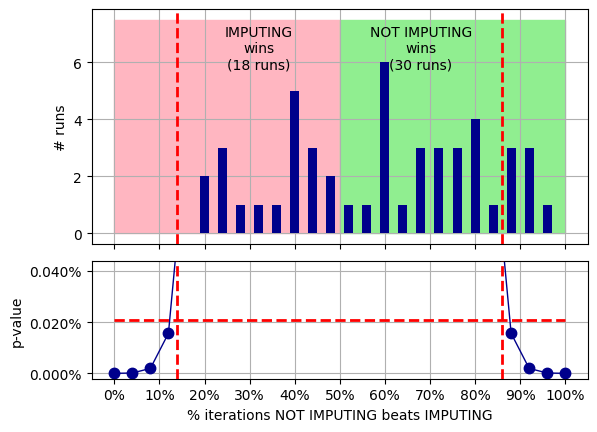

In [12]:
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=.1)

ymin_ax0 = - (vc.max() * 1.25) * .05
ymax_ax0 = (vc.max() * 1.25) * 1.05
ymin_ax1 = - (pvalue_threshold_bonferroni * 2) * .05
ymax_ax1 = pvalue_threshold_bonferroni * 2 * 1.05

ax[0].fill_between([0.0, 0.5], y1=vc.max() * 1.25, color="lightpink", zorder=0)
ax[0].fill_between([0.5, 1.0], y1=vc.max() * 1.25, color="lightgreen", zorder=0)
ax[0].grid(zorder=1)
ax[0].bar(vc.index, vc, width=.02, color="darkblue", zorder=2)
ax[0].vlines(lsignif, ymin_ax0, ymax_ax0, ls="--", color="red", lw=2, zorder=3)
ax[0].vlines(rsignif, ymin_ax0, ymax_ax0, ls="--", color="red", lw=2, zorder=3)
ax[0].text(x=(lsignif+.5)/2, y=vc.max()+.5, s=f"IMPUTING\nwins\n({vc[vc.index < .5].sum()} runs)", ha="center", va="center", zorder=4)
ax[0].text(x=(rsignif+.5)/2, y=vc.max()+.5, s=f"NOT IMPUTING\nwins\n({vc[vc.index > .5].sum()} runs)", ha="center", va="center", zorder=4)
ax[0].set_ylim([ymin_ax0, ymax_ax0])
ax[0].set_ylabel("# runs")
ax[0].set_xticks(np.linspace(0,1,11))

ax[1].grid(zorder=0)
ax[1].plot(pvalues.index, pvalues, "-o", lw=1, markersize=7.5, color="darkblue")
ax[1].hlines(pvalue_threshold_bonferroni, 0, 1, ls="--", color="red", lw=2, zorder=2)
ax[1].vlines(lsignif, ymin_ax1, ymax_ax1, ls="--", color="red", lw=2, zorder=3)
ax[1].vlines(rsignif, ymin_ax1, ymax_ax1, ls="--", color="red", lw=2, zorder=3)
ax[1].set_ylim(ymin_ax1, ymax_ax1)
ax[1].set_ylabel("p-value")
yticks = ax[1].get_yticks()[1:-1]
xticks = ax[1].get_xticks()
ax[1].set_yticks(ticks=yticks, labels=["{:.3%}".format(y) for y in yticks])
ax[1].set_xticks(ticks=xticks, labels=["{:.0%}".format(x) for x in xticks])
ax[1].set_xlabel("% iterations NOT IMPUTING beats IMPUTING")

fig.savefig("not_imputing_vs_imputing.png", bbox_inches="tight", dpi=200)